In [770]:
!pip install shapely

In [771]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
import string
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
import unicodedata
import datetime
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns

from sklearn.decomposition import NMF as NMF_sklearn

In [182]:
data = pd.read_csv('poller_opposites_election_hackathon/tweets.csv')

In [612]:
data_copy = data.copy()

In [203]:

def prepare_tweet(tweet) -> str:
  ''' 
  Takes a string, removes punctuation, non-ascii, and stems remaining text
  input:
    str tweet: a string representing a tweet's text
  output:
    str tweet: a stemmed tweet with no punctuation or non-ascii characters
  '''
  tweet = tweet.translate(str.maketrans('','',string.punctuation))
  tweet = str(tweet.encode("ascii","ignore"))[2:-1]
  stemmer = EnglishStemmer()
  tokens = word_tokenize(tweet)
  tweet = ''
  for token in tokens:
    tweet = tweet+stemmer.stem(token)+" "
  return tweet[:-1]

In [613]:
data_copy['clean_text'] = data_copy['full_text'].apply(prepare_tweet)

In [615]:
data_copy.drop(axis=0, labels=[110181,110182], inplace=True)

In [616]:
data_copy['description'] = data_copy['user'].apply(lambda X: X[X.find("'description': ")+16:X.find(", 'url':")-1])

In [617]:
data_copy['location'] = data_copy['user'].apply(lambda X: X[X.find("'location': ")+13:X.find(", 'description': ")-1])

In [618]:
data_copy['language'] = data_copy['user'].apply(lambda X: X[X.find("'lang': ")+9:X.find(", 'contributors_enabled': ")-1])

In [619]:
data_copy['followers'] = data_copy['user'].apply(lambda X: X[X.find("'followers_count': ")+19:X.find(", 'friends_count': ")-1])

In [620]:
data_copy['friends'] = data_copy['user'].apply(lambda X: X[X.find("'friends_count': ")+18:X.find(", 'listed_count': ")-1])

In [621]:
data_copy['user_name'] = data_copy['user'].apply(lambda X: X[X.find("'screen_name': ")+16:X.find(", 'location': ")-1])

In [622]:
def device(x):
    devices = ['iPhone','iPad','Android','Web App', 'Media Studio', 'Echofon','TweetDeck', 'viriya', 'Twibble.io', 'dlvr.it', 'Tweetbot','TwitPanePlus','SocialFlow', 'News Aggregator', 'Instagram', 'Bot', 'bot', 'iphone','android','web app','News','news']

    for dev in devices:
        if dev in str(x):
            return dev
        else:
            continue

In [623]:
data_copy['device'] = data_copy['source'].apply(device)

In [624]:
data_copy['device'].value_counts()

iPhone             62080
Android            38756
Web App            29655
iPad                8049
TweetDeck            459
Tweetbot             193
dlvr.it               83
News                  56
Bot                   53
Echofon               47
SocialFlow            45
news                  19
bot                   19
Instagram             14
Media Studio           8
TwitPanePlus           5
Twibble.io             5
News Aggregator        1
android                1
viriya                 1
Name: device, dtype: int64

In [625]:
data_copy

,Unnamed: 0,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,...,extended_entities,withheld_in_countries,clean_text,description,location,language,followers,friends,user_name,device
0,0,2020-09-29 23:59:56+00:00,1311093385688735744,1311093385688735744,"Bide, a professional debater?? Hardly!! More ...",False,"[0, 71]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,NaN,bide a profession debat hard more like a profe...,Conservative/#MAGA/ #WWG1WGA /MbrNRA/#Trump202...,America,on,406,99,sfshores53,Web App
1,1,2020-09-29 23:59:58+00:00,1311093394400333824,1311093394400333824,RT @DarDar458: #PresidentialDebate #Debates202...,False,"[0, 73]","{'hashtags': [{'text': 'PresidentialDebate', '...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,rt dardar458 presidentialdeb debates2020 trump...,Canadian 🇨🇦 Windmill Cancer Survivor. I follow...,Canada,on,3103,140,ProudCdn100,iPhone
2,2,2020-09-30 00:00:00+00:00,1311093401652277252,1311093401652277248,How can Biden stand a chance against Trump in ...,False,"[0, 280]","{'hashtags': [{'text': 'VarneyCo', 'indices': ...","<a href=""https://studio.twitter.com"" rel=""nofo...",NaN,...,"{'media': [{'id': 1310969778111217665, 'id_str...",NaN,how can biden stand a chanc against trump in t...,Airing Weekdays at 9AM ET on the Fox Business ...,New York,on,66353,3,Varneyco,Media Studio
3,3,2020-09-30 00:00:02+00:00,1311093410737070086,1311093410737070080,RT @abbydphillip: Very reminiscent of pre-2018...,False,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,rt abbydphillip veri reminisc of pre2018 elect...,Politics reporter covering elections & voting ...,"New York, NY",on,2173,71,grace_panetta,iPhone
4,4,2020-09-30 00:00:04+00:00,1311093419100561408,1311093419100561408,RT @RudyGiuliani: Why was Corrupt Biden’s son ...,False,"[0, 110]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,rt rudygiuliani whi was corrupt biden son be p...,"wife, mother, grandmother, southerner, conserv...",Kentucky/Florida,on,89,35,susuclarkson,iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140333,140332,2020-10-02 23:59:13+00:00,1312180367873339392,1312180367873339392,RT @realDonaldTrump: https://t.co/B4H105KVSs,False,"[0, 44]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,"{'media': [{'id': 1312158363715764225, 'id_str...",NaN,rt realdonaldtrump httpstcob4h105kvss,I’m just your average fed up & fired up Americ...,"Washington, USA",on,41,3,matt_aho,iPhone
140334,140333,2020-10-02 23:59:27+00:00,1312180427755458560,1312180427755458560,"@ScottAdamsSays Hi, my son died, please vote J...",False,"[16, 55]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.31211e+18,...,NaN,NaN,scottadamssay hi my son die pleas vote joe biden,Connecting with you\nThank you ^-^\n\n🌎🇫🇷🐸1️⃣7️⃣,decentralized,on,38,32,tidoodoo,Web App
140335,140334,2020-10-02 23:59:03+00:00,1312180327012474881,1312180327012474880,@FoxNews can stick it where the sun doesn't sh...,False,"[0, 50]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,foxnew can stick it where the sun doesnt shine...,Making moves for change,,on,11,5,hatenscorpions,Android
140336,140335,2020-10-02 23:59:41+00:00,1312180486840619008,1312180486840619008,RT @aaronjcarpenter: I can’t stress this enoug...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,rt aaronjcarpent i cant stress this enough if ...,Retired Navy Pilot & proud Naval Academy gradu...,New Hampshire,on,6736,19

In [626]:
col = ['id', 'id_str', 'truncated',
       'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status', 'favorited',
       'retweeted', 'possibly_sensitive',
       'extended_entities', 'withheld_in_countries', ]
final_df = data_copy.drop(axis=1, columns=col)

In [637]:
final_df['created_at']= pd.to_datetime(final_df['created_at'])
final_df['date'] = final_df.created_at.apply(lambda x: x.date)

In [638]:
final_df

,Unnamed: 0,created_at,full_text,user,retweet_count,favorite_count,lang,retweeted_status,clean_text,description,location,language,followers,friends,user_name,device,hour,dayofweek,date
0,0,2020-09-29 23:59:56+00:00,"Bide, a professional debater?? Hardly!! More ...","{'id': 117904481, 'id_str': '117904481', 'name...",0.0,0,en,NaN,bide a profession debat hard more like a profe...,Conservative/#MAGA/ #WWG1WGA /MbrNRA/#Trump202...,America,on,406,99,sfshores53,Web App,23,1,2020-09-29
1,1,2020-09-29 23:59:58+00:00,RT @DarDar458: #PresidentialDebate #Debates202...,"{'id': 30140760, 'id_str': '30140760', 'name':...",1.0,0,und,{'created_at': 'Tue Sep 29 23:55:42 +0000 2020...,rt dardar458 presidentialdeb debates2020 trump...,Canadian 🇨🇦 Windmill Cancer Survivor. I follow...,Canada,on,3103,140,ProudCdn100,iPhone,23,1,2020-09-29
2,2,2020-09-30 00:00:00+00:00,How can Biden stand a chance against Trump in ...,"{'id': 281610530, 'id_str': '281610530', 'name...",25.0,100,en,NaN,how can biden stand a chanc against trump in t...,Airing Weekdays at 9AM ET on the Fox Business ...,New York,on,66353,3,Varneyco,Media Studio,0,2,2020-09-30
3,3,2020-09-30 00:00:02+00:00,RT @abbydphillip: Very reminiscent of pre-2018...,"{'id': 88223320, 'id_str': '88223320', 'name':...",351.0,0,en,{'created_at': 'Tue Sep 29 23:00:28 +0000 2020...,rt abbydphillip veri reminisc of pre2018 elect...,Politics reporter covering elections & voting ...,"New York, NY",on,2173,71,grace_panetta,iPhone,0,2,2020-09-30
4,4,2020-09-30 00:00:04+00:00,RT @RudyGiuliani: Why was Corrupt Biden’s son ...,"{'id': 44295160, 'id_str': '44295160', 'name':...",15672.0,0,en,{'created_at': 'Tue Sep 29 19:07:59 +0000 2020...,rt rudygiuliani whi was corrupt biden son be p...,"wife, mother, grandmother, southerner, conserv...",Kentucky/Florida,on,89,35,susuclarkson,iPhone,0,2,2020-09-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140333,140332,2020-10-02 23:59:13+00:00,RT @realDonaldTrump: https://t.co/B4H105KVSs,"{'id': 27780458, 'id_str': '27780458', 'name':...",131058.0,0,und,{'created_at': 'Fri Oct 02 22:31:56 +0000 2020...,rt realdonaldtrump httpstcob4h105kvss,I’m just your average fed up & fired up Americ...,"Washington, USA",on,41,3,matt_aho,iPhone,23,4,2020-10-02
140334,140333,2020-10-02 23:59:27+00:00,"@ScottAdamsSays Hi, my son died, please vote J...","{'id': 1081132982449119232, 'id_str': '1081132...",0.0,0,en,NaN,scottadamssay hi my son die pleas vote joe biden,Connecting with you\nThank you ^-^\n\n🌎🇫🇷🐸1️⃣7️⃣,decentralized,on,38,32,tidoodoo,Web App,23,4,2020-10-02
140335,140334,2020-10-02 23:59:03+00:00,@FoxNews can stick it where the sun doesn't sh...,"{'id': 2290692901, 'id_str': '2290692901', 'na...",0.0,0,en,NaN,foxnew can stick it where the sun doesnt shine...,Making moves for change,,on,11,5,hatenscorpions,Android,23,4,2020-10-02
140336,140335,2020-10-02 23:59:41+00:00,RT @aaronjcarpenter: I can’t stress this enoug...,"{'id': 1931084401, 'id_str': '1931084401', 'na...",27.0,0,en,{'created_at': 'Fri Oct 02 23:58:26 +0000 2020...,rt aaronjcarpent i cant stress this enough if ...,Retired Navy Pilot & proud Naval Academy gradu...,New Hampshire,on,6736,19,RuthieRedSox,iPhone,23,4,2020-10-02


In [605]:
final_df['clean_description'] = final_df['description'].apply(prepare_tweet)

In [606]:
final_df['combined_text'] = final_df['clean_text'] + final_df['clean_description']

In [775]:
final_df.to_json('clean_df.json')


In [774]:
final_df['location'].value_counts().head(25)

                       54690
United States           4292
USA                     1730
California, USA         1436
Texas, USA              1144
Florida, USA            1123
Los Angeles, CA          830
New York, USA            509
New York, NY             474
Chicago, IL              460
Pennsylvania, USA        440
Washington, DC           435
Texas                    426
North Carolina, USA      407
Ohio, USA                403
New Jersey, USA          392
Michigan, USA            385
Houston, TX              372
Arizona, USA             360
Georgia, USA             340
Canada                   331
Atlanta, GA              310
Virginia, USA            294
Illinois, USA            288
Colorado, USA            280
Name: location, dtype: int64

In [699]:
state_long = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

state_abbv = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

In [725]:
def location_clean(x):

    if x == 'United States':
        return 'USA'
    elif x == 'USA':
        return 'USA'
    elif x == 'America':
        return 'USA'
    elif x == 'United States of America':
        return 'USA'
    elif x == ' USA':
        return 'USA'
    elif x == 'U.S.A.':
        return 'USA'
    elif x == 'Los Angeles':
        return 'CA'
    elif x == 'Boston':
        return 'MA'
    elif x == 'Chicago':
        return 'IL'
    elif x == 'Seattle':
        return 'WA'
    elif x == 'USA ':
        return 'USA'
    elif x == 'UNITED STATES':
        return 'USA'
    else:
        for sl, sa in zip(state_long, state_abbv):
            if sl in x or sa in x:
                return sa
            else:
                continue

In [726]:
final_df['clean_loc'] = final_df['location'].apply(location_clean)

In [773]:
final_df[]

,Unnamed: 0,created_at,full_text,user,retweet_count,favorite_count,lang,retweeted_status,clean_text,description,location,language,followers,friends,user_name,device,hour,dayofweek,date,clean_loc
0,0,2020-09-29 23:59:56+00:00,"Bide, a professional debater?? Hardly!! More ...","{'id': 117904481, 'id_str': '117904481', 'name...",0.0,0,en,NaN,bide a profession debat hard more like a profe...,Conservative/#MAGA/ #WWG1WGA /MbrNRA/#Trump202...,America,on,406,99,sfshores53,Web App,23,1,2020-09-29,None
1,1,2020-09-29 23:59:58+00:00,RT @DarDar458: #PresidentialDebate #Debates202...,"{'id': 30140760, 'id_str': '30140760', 'name':...",1.0,0,und,{'created_at': 'Tue Sep 29 23:55:42 +0000 2020...,rt dardar458 presidentialdeb debates2020 trump...,Canadian 🇨🇦 Windmill Cancer Survivor. I follow...,Canada,on,3103,140,ProudCdn100,iPhone,23,1,2020-09-29,None
2,2,2020-09-30 00:00:00+00:00,How can Biden stand a chance against Trump in ...,"{'id': 281610530, 'id_str': '281610530', 'name...",25.0,100,en,NaN,how can biden stand a chanc against trump in t...,Airing Weekdays at 9AM ET on the Fox Business ...,New York,on,66353,3,Varneyco,Media Studio,0,2,2020-09-30,NY
3,3,2020-09-30 00:00:02+00:00,RT @abbydphillip: Very reminiscent of pre-2018...,"{'id': 88223320, 'id_str': '88223320', 'name':...",351.0,0,en,{'created_at': 'Tue Sep 29 23:00:28 +0000 2020...,rt abbydphillip veri reminisc of pre2018 elect...,Politics reporter covering elections & voting ...,"New York, NY",on,2173,71,grace_panetta,iPhone,0,2,2020-09-30,NY
4,4,2020-09-30 00:00:04+00:00,RT @RudyGiuliani: Why was Corrupt Biden’s son ...,"{'id': 44295160, 'id_str': '44295160', 'name':...",15672.0,0,en,{'created_at': 'Tue Sep 29 19:07:59 +0000 2020...,rt rudygiuliani whi was corrupt biden son be p...,"wife, mother, grandmother, southerner, conserv...",Kentucky/Florida,on,89,35,susuclarkson,iPhone,0,2,2020-09-30,FL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140333,140332,2020-10-02 23:59:13+00:00,RT @realDonaldTrump: https://t.co/B4H105KVSs,"{'id': 27780458, 'id_str': '27780458', 'name':...",131058.0,0,und,{'created_at': 'Fri Oct 02 22:31:56 +0000 2020...,rt realdonaldtrump httpstcob4h105kvss,I’m just your average fed up & fired up Americ...,"Washington, USA",on,41,3,matt_aho,iPhone,23,4,2020-10-02,WA
140334,140333,2020-10-02 23:59:27+00:00,"@ScottAdamsSays Hi, my son died, please vote J...","{'id': 1081132982449119232, 'id_str': '1081132...",0.0,0,en,NaN,scottadamssay hi my son die pleas vote joe biden,Connecting with you\nThank you ^-^\n\n🌎🇫🇷🐸1️⃣7️⃣,decentralized,on,38,32,tidoodoo,Web App,23,4,2020-10-02,None
140335,140334,2020-10-02 23:59:03+00:00,@FoxNews can stick it where the sun doesn't sh...,"{'id': 2290692901, 'id_str': '2290692901', 'na...",0.0,0,en,NaN,foxnew can stick it where the sun doesnt shine...,Making moves for change,,on,11,5,hatenscorpions,Android,23,4,2020-10-02,None
140336,140335,2020-10-02 23:59:41+00:00,RT @aaronjcarpenter: I can’t stress this enoug...,"{'id': 1931084401, 'id_str': '1931084401', 'na...",27.0,0,en,{'created_at': 'Fri Oct 02 23:58:26 +0000 2020...,rt aaronjcarpent i cant stress this enough if ...,Retired Navy Pilot & proud Naval Academy gradu...,New Hampshire,on,6736,19,RuthieRedSox,iPhone,23,4,2020-10-02,NH


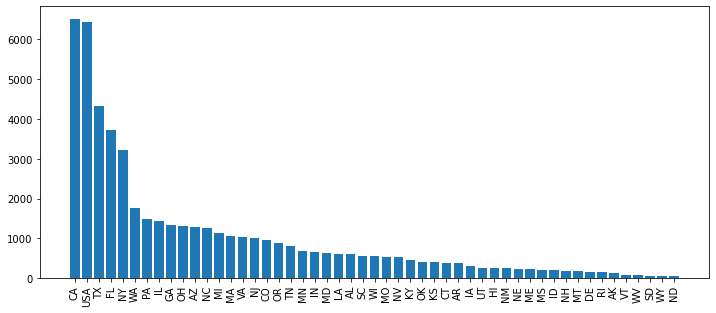

In [785]:
data_plot = final_df.groupby(['clean_loc']).count()['location'].sort_values(ascending=False)
plt.figure(figsize=(12,5))
plt.bar(height=data_plot, x=data_plot.index)
plt.xticks(rotation=90);


<BarContainer object of 4 artists>

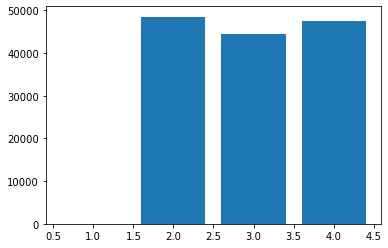

In [742]:
plt.bar(height=final_df.groupby(['dayofweek']).count()['location'], x=final_df.groupby(['dayofweek']).count().index)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <a list of 10 Text major ticklabel objects>)

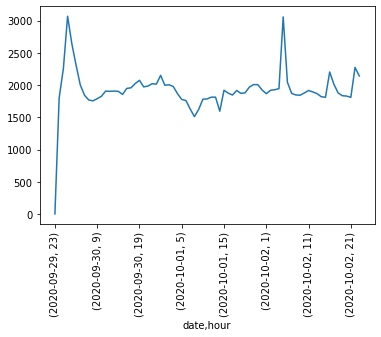

In [760]:
final_df.groupby(['date','hour']).count()['location'].plot()
plt.xticks(rotation=90)

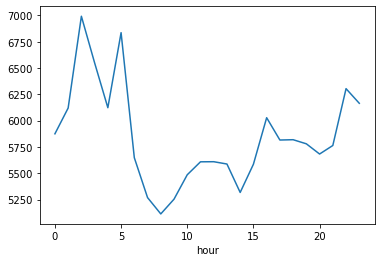

In [736]:
final_df.groupby(['hour']).count()['location'].plot()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

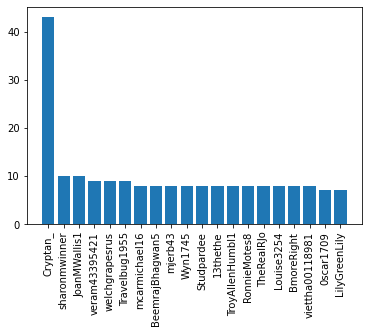

In [759]:
plt.bar(height=final_df.groupby(['user_name']).count()['location'].sort_values(ascending=False).head(2),x=final_df.groupby(['user_name']).count()['location'].sort_values(ascending=False).head(20).index)
plt.xticks(rotation=90)

In [767]:
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
cities

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)
...,...,...
197,Cairo,POINT (31.24802 30.05191)
198,Tokyo,POINT (139.74946 35.68696)
199,Paris,POINT (2.33139 48.86864)
200,Santiago,POINT (-70.66899 -33.44807)


In [772]:
usa = gpd.read_file('./maps/states_21basic/states.shp')

DriverError: ./maps/states_21basic/states.shp: No such file or directory

In [578]:
content = final_df['combined_text']
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, min_df=10)


In [579]:
X = vectorizer.fit_transform(content)

In [600]:
features = vectorizer.get_feature_names()

In [589]:
nmf = NMF_sklearn(n_components=25, max_iter=100, random_state=12345, alpha=0.0)
W = nmf.fit_transform(X)
H = nmf.components_

In [590]:
for i, row in enumerate(H):
        top_ten = np.argsort(row)[::-1][:10]
        print(np.array(features)[top_ten])

['trump' 'donald' 'melania' '2020' 'coronavirus' 'becaus' 'campaign'
 'covid19' 'covid' 'ladi']
['process' 'begin' 'immedi' 'quarantin' 'recoveri' 'covid19' 'tonight'
 'flotus' 'posit' 'test']
['realdonaldtrump' 'flotus' 'httpstcohusfkhqsyc' 'httpstcob4h105kvss'
 'thank' 'radic' 'herschelwalk' 'left' 'liar' 'seanhann']
['negat' 'jill' 'im' 'happi' 'concern' 'messag' 'everyon' 'thank' 'report'
 'covid']
['white' 'condemn' 'supremacist' 'supremaci' 'refus' 'denounc' 'hous'
 'ask' 'didnt' 'ntrump']
['biden' 'joe' 'son' 'hunter' 'antifa' 'lie' 'wear' 'idea' 'realjameswood'
 'campaign']
['rt' 'debates2020' 'year' 'httpstcohusfkhqsyc' 'ntrump' 'democrat'
 'httpstcob4h105kvss' 'projectlincoln' 'today' 'gtconway3d']
['joebiden' 'donald' 'weve' 'worst' 'battl' 'come' 'beau' 'loser' 'moment'
 'night']
['debat' 'presidenti' 'commiss' 'watch' 'rule' 'chang' 'won' 'moder'
 'allow' 'second']
['like' 'dont' 'peopl' 'know' 'think' 'make' 'just' 'live' 'thing' 'im']
['maga' 'kag' 'trump2020' 'patriot' 

In [595]:
data_copy['user'][1]

"{'id': 30140760, 'id_str': '30140760', 'name': '🌊🇨🇦Lizbeth 🇨🇦🌊', 'screen_name': 'ProudCdn100', 'location': 'Canada', 'description': 'Canadian 🇨🇦 Windmill Cancer Survivor. I follow back all #Resisters. #BlueNoMatterWho #BlackLivesMatter #NoDMs #RightMatters', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 31031, 'friends_count': 31404, 'listed_count': 12, 'created_at': 'Fri Apr 10 02:47:29 +0000 2009', 'favourites_count': 95405, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 11105, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': '352726', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme5/bg.gif', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme5/bg.gif', 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1235416

In [596]:
data_copy['retweeted_status'][1]

'{\'created_at\': \'Tue Sep 29 23:55:42 +0000 2020\', \'id\': 1311092317466624005, \'id_str\': \'1311092317466624005\', \'full_text\': \'#PresidentialDebate #Debates2020 #TrumpIsANationalDisgrace https://t.co/GOhLaDJLeN\', \'truncated\': False, \'display_text_range\': [0, 58], \'entities\': {\'hashtags\': [{\'text\': \'PresidentialDebate\', \'indices\': [0, 19]}, {\'text\': \'Debates2020\', \'indices\': [20, 32]}, {\'text\': \'TrumpIsANationalDisgrace\', \'indices\': [33, 58]}], \'symbols\': [], \'user_mentions\': [], \'urls\': [{\'url\': \'https://t.co/GOhLaDJLeN\', \'expanded_url\': \'https://twitter.com/JenniferJJacobs/status/1311068232976080896\', \'display_url\': \'twitter.com/JenniferJJacob…\', \'indices\': [59, 82]}]}, \'source\': \'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>\', \'in_reply_to_status_id\': None, \'in_reply_to_status_id_str\': None, \'in_reply_to_user_id\': None, \'in_reply_to_user_id_str\': None, \'in_reply_to_screen_name\

In [597]:
data_copy['location'][1]

'Canada'